## Лабораторная работа №3: Линейные модели. Кросс-валидация.<br>
## Вариант 28 <br>
## ПМИ3-1, Чижевский И.М. <br>

### Условие задачи для варианта 28:
| Вариант | Проверка | Набор данных     | Зависимая переменная       | НОП*                                                                                              | ФОП*                                             |
|:--------:|:--------:|:----------------:|:--------------------------:|:------------------------------------------------------------------------------------------------:|:------------------------------------------------:|
| 28      | K-VAL(10) | auto_for_lab  | mpg / пробег автомобиля на галлоне топлива | displacement /объем двигателя (в кубических дюймах)| weight/ масса (в фунтах) | cyl_over_4/ 1 если число цилиндров больше 4 | <br> <br>

*НОП, ФОП - объясняющие переменные: НОП - непрерывные, ФОП - фиктивные.

In [45]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [55]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [47]:

my_seed = 28  # номер варианта
np.random.seed(my_seed)

# Загрузка данных
url = 'https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv'
df = pd.read_csv(url)

# Оставляем только нужные переменные
df = df[['mpg', 'displacement', 'weight', 'cyl_over_4']]

# Разделение на обучающую (80%) и отложенную (20%) выборки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=my_seed)

print(f"Обучающая выборка: {train_df.shape}")
print(f"Тестовая выборка: {test_df.shape}")


Обучающая выборка: (313, 4)
Тестовая выборка: (79, 4)


In [48]:
df.head()

,mpg,displacement,weight,cyl_over_4
0,18.0,307.0,3504,1
1,15.0,350.0,3693,1
2,18.0,318.0,3436,1
3,16.0,304.0,3433,1
4,17.0,302.0,3449,1


In [49]:
df.dtypes

,0
mpg,float64
displacement,float64
weight,int64
cyl_over_4,int64


In [50]:
df.isna().sum()

,0
mpg,0
displacement,0
weight,0
cyl_over_4,0


              mpg  displacement       weight  cyl_over_4
count  313.000000    313.000000   313.000000  313.000000
mean    23.273802    194.797125  2976.664537    0.488818
std      7.762336    104.092590   845.473790    0.500675
min      9.000000     68.000000  1649.000000    0.000000
25%     17.500000    105.000000  2223.000000    0.000000
50%     22.000000    151.000000  2807.000000    0.000000
75%     29.000000    302.000000  3620.000000    1.000000
max     46.600000    455.000000  5140.000000    1.000000


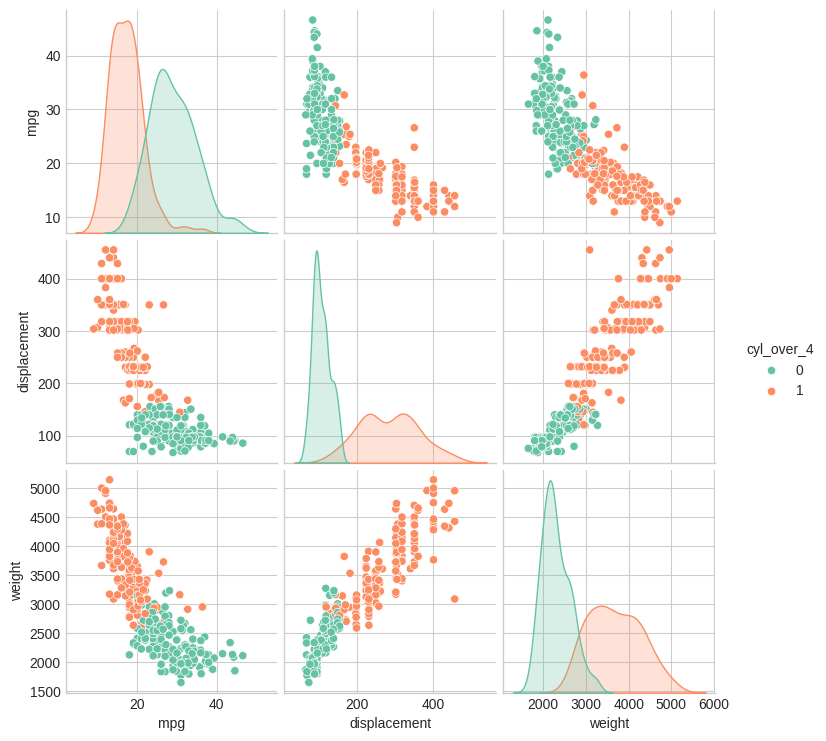

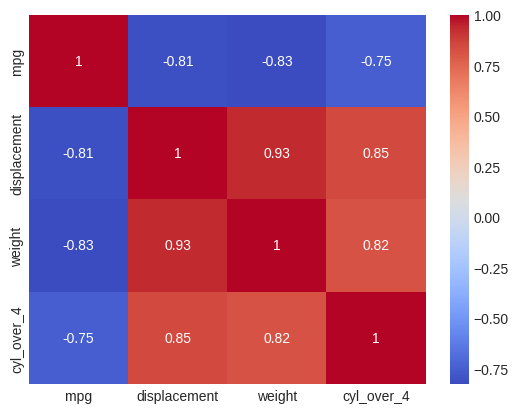

In [44]:
# Описательные статистики
print(train_df.describe())

# Матрица графиков разброса
sns.pairplot(train_df, hue='cyl_over_4')
plt.show()

# Корреляционная матрица
corr = train_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Проверка нормальности Y

Статистика: 0.968, p-value: 0.000
Распределение не нормальное


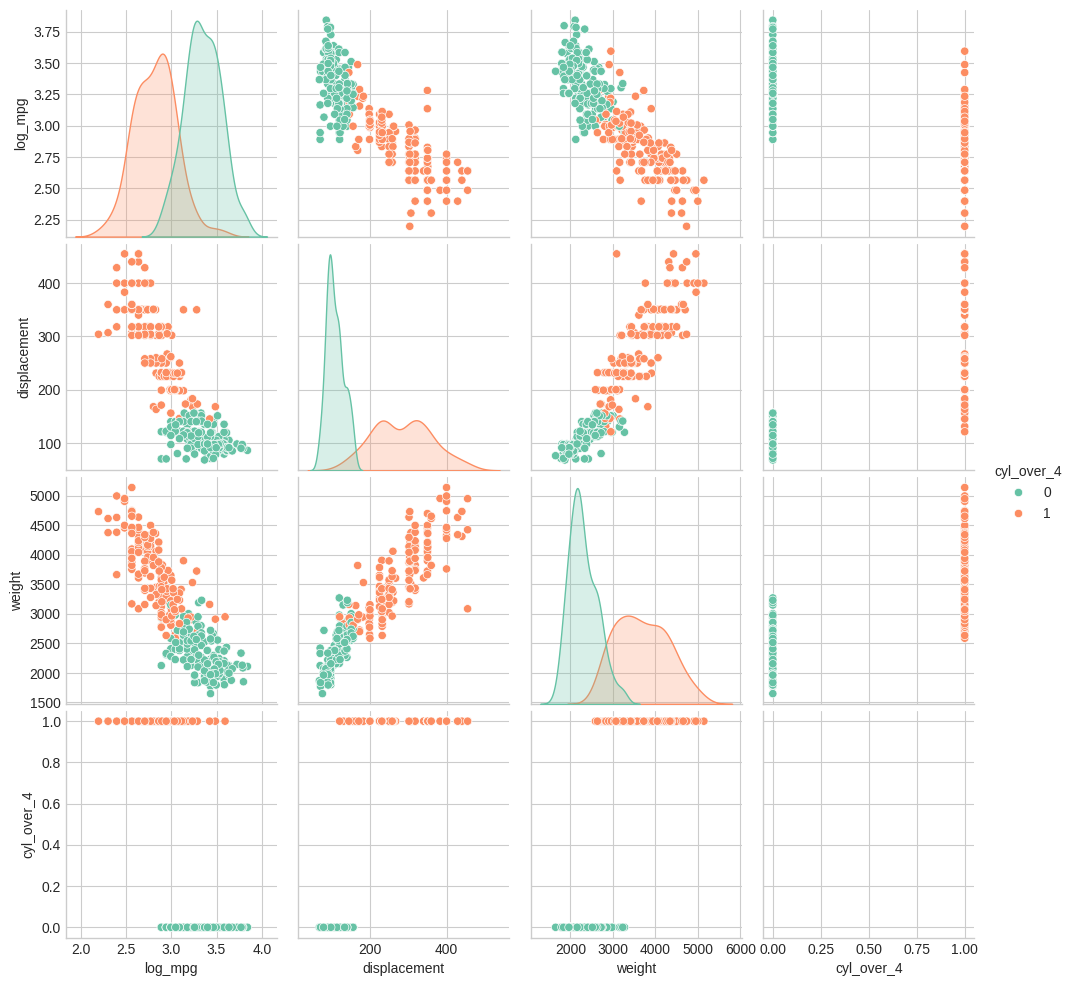

In [51]:
# Тест Шапиро-Уилка для mpg
stat, p = shapiro(train_df['mpg'])
print(f'Статистика: {stat:.3f}, p-value: {p:.3f}')
if p > 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное')
    train_df['log_mpg'] = np.log(train_df['mpg'])
    test_df['log_mpg'] = np.log(test_df['mpg'])
    # Повторный анализ с log(mpg)
    sns.pairplot(train_df, vars=['log_mpg', 'displacement', 'weight', 'cyl_over_4'], hue='cyl_over_4')
    plt.show()

Спецификации моделей

In [52]:
# Создание взаимодействий
train_df['displacement_weight'] = train_df['displacement'] * train_df['weight']
train_df['displacement_cyl'] = train_df['displacement'] * train_df['cyl_over_4']
train_df['weight_cyl'] = train_df['weight'] * train_df['cyl_over_4']

test_df['displacement_weight'] = test_df['displacement'] * test_df['weight']
test_df['displacement_cyl'] = test_df['displacement'] * test_df['cyl_over_4']
test_df['weight_cyl'] = test_df['weight'] * test_df['cyl_over_4']

# Список спецификаций
specs = [
    ['displacement', 'weight', 'cyl_over_4'],
    ['displacement', 'weight', 'cyl_over_4', 'displacement_weight'],
    ['displacement', 'weight', 'cyl_over_4', 'displacement_cyl'],
    ['displacement', 'weight', 'cyl_over_4', 'weight_cyl'],
    ['displacement', 'weight', 'cyl_over_4', 'displacement_weight', 'displacement_cyl', 'weight_cyl']
]

Оценка моделей и кросс-валидация

In [53]:
# Функция для кросс-валидации
def cv_score(model, X, y, cv=10):
    kf = KFold(n_splits=cv, shuffle=True, random_state=my_seed)
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    return -scores.mean()

# Оценка моделей для mpg
lm = LinearRegression()
results_mpg = []
for spec in specs:
    X = train_df[spec]
    y = train_df['mpg']
    mse = cv_score(lm, X, y, cv=10)
    results_mpg.append((spec, mse))

# Оценка моделей для log(mpg) (если логарифмировали)
results_log_mpg = []
if 'log_mpg' in train_df.columns:
    for spec in specs:
        X = train_df[spec]
        y = train_df['log_mpg']
        mse = cv_score(lm, X, y, cv=10)
        results_log_mpg.append((spec, mse))

# Выбор лучших моделей
best_mpg = min(results_mpg, key=lambda x: x[1])
best_log_mpg = min(results_log_mpg, key=lambda x: x[1]) if results_log_mpg else None

print(f"Лучшая модель для mpg: {best_mpg[0]}, MSE: {best_mpg[1]:.3f}")
if best_log_mpg:
    print(f"Лучшая модель для log(mpg): {best_log_mpg[0]}, MSE: {best_log_mpg[1]:.3f}")

Лучшая модель для mpg: ['displacement', 'weight', 'cyl_over_4', 'displacement_weight'], MSE: 17.202
Лучшая модель для log(mpg): ['displacement', 'weight', 'cyl_over_4', 'displacement_weight', 'displacement_cyl', 'weight_cyl'], MSE: 0.026


Прогноз на отложенных данных и интерпретация

In [54]:
# Обучение лучшей модели для mpg
X_train = train_df[best_mpg[0]]
y_train = train_df['mpg']
model_mpg = lm.fit(X_train, y_train)

# Прогноз на тестовой выборке
X_test = test_df[best_mpg[0]]
y_test = test_df['mpg']
y_pred = model_mpg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)

print(f"MSE на отложенных данных (mpg): {mse_test:.3f}")
print(f"Коэффициенты модели: {model_mpg.coef_}")
print(f"Константа: {model_mpg.intercept_:.3f}")

# Аналогично для log(mpg), если использовалась
if best_log_mpg:
    X_train_log = train_df[best_log_mpg[0]]
    y_train_log = train_df['log_mpg']
    model_log = lm.fit(X_train_log, y_train_log)
    X_test_log = test_df[best_log_mpg[0]]
    y_test_log = test_df['log_mpg']
    y_pred_log = model_log.predict(X_test_log)
    mse_test_log = mean_squared_error(np.exp(y_test_log), np.exp(y_pred_log))
    print(f"MSE на отложенных данных (log(mpg)): {mse_test_log:.3f}")
    print(f"Коэффициенты модели (log): {model_log.coef_}")
    print(f"Константа (log): {model_log.intercept_:.3f}")

MSE на отложенных данных (mpg): 16.736
Коэффициенты модели: [-7.94892021e-02 -8.24735875e-03 -1.82742117e-01  1.67506603e-05]
Константа: 52.316
MSE на отложенных данных (log(mpg)): 17.478
Коэффициенты модели (log): [-8.86272959e-04 -4.02840637e-04  2.26817964e-01  6.13483005e-07
 -2.53343963e-03  4.73698619e-05]
Константа (log): 4.213
